In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

from plstm_cell import PLSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# load files
RNN_input = np.load('/content/drive/MyDrive/aspen data/RNN_input.npy')
RNN_output = np.load('/content/drive/MyDrive/aspen data/RNN_output.npy')

In [ ]:
print(RNN_input.shape)
print(RNN_output.shape)

(9901, 100, 10)
(9901, 1, 4)


In [ ]:
# split into testing and training data

X_train, X_test, y_train, y_test1 = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)


# split into validation and training data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=246)

In [ ]:
t_train = X_train[:, :, -1]
t_val = X_val[:,:,-1]
t_test = X_test[:, :, -1]
print(f't_train, t_val, t_test shapes: {t_train.shape}, {t_val.shape}, {t_test.shape}')

t_train, t_val, t_test shapes: (5197, 100), (1733, 100), (2971, 100)


In [ ]:
# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 10))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 4))

num_timesteps = 100
max_length = 100

X_train = scaler_X.transform(X_train.reshape(-1, 10)).reshape(-1,max_length,10)
X_test = scaler_X.transform(X_test.reshape(-1, 10)).reshape(-1,num_timesteps,10)
X_val = scaler_X.transform(X_val.reshape(-1, 10)).reshape(-1,num_timesteps,10)

y_train = scaler_y.transform(y_train.reshape(-1,4)).reshape(-1,1,4)
y_test = scaler_y.transform(y_test1.reshape(-1,4)).reshape(-1,1,4)
y_val = scaler_y.transform(y_val.reshape(-1, 4)).reshape(-1,1,4)


In [ ]:
# compute mean and std for the data
print(f'input means are: {scaler_X.mean_}')
print(f'input std are: {scaler_X.scale_}')
print(f'output means are {scaler_y.mean_}')
print(f'ouput std are{scaler_y.scale_}')

input means are: [-1.61304599e-01 -4.17184914e+01 -2.52376371e-03  4.08974408e+00
 -3.61157591e-02 -3.25992220e+00 -8.26270509e+00  2.32897221e+00
 -2.03174653e+01  5.05100000e+01]
input std are: [4.99739741e+00 3.47504773e+02 1.19973458e-01 4.48137701e+01
 3.68233149e-01 5.37921640e+00 5.59565624e+00 3.03769961e+00
 1.47119041e+01 2.88833845e+01]
output means are [ -3.3154411   -8.34356412   2.33346785 -20.39422264]
ouput std are[ 5.34122211  5.49663143  3.04085782 14.53833797]


In [ ]:
def sampler(min_num_points = 2, max_num_points = 25, max_duration = 100, count = 0):

    # get time to sample data
    random.seed(count)
    np.random.seed(count)

    num_points = random.randint(min_num_points, max_num_points) #num of points
    min_duration = max_num_points
    duration = random.randint(min_duration, max_duration) #interval
    start = random.randint(0, (max_duration - duration)) #start
#     start = int(start)

    asyn_t = np.random.choice(np.arange(start, max_duration), size = num_points, replace = False)
    sorted_t = np.sort(asyn_t)

    # print(f'num points:{num_points}, duration:{duration}, start:{start}')
    return sorted_t

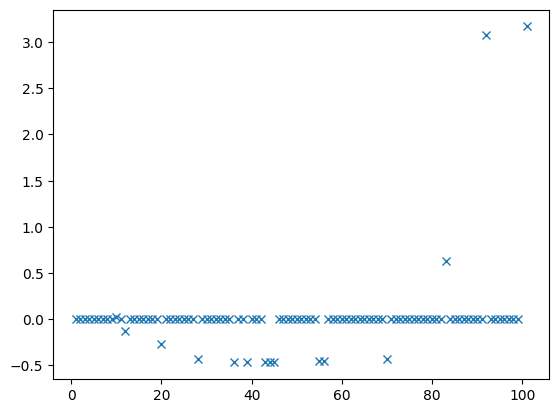

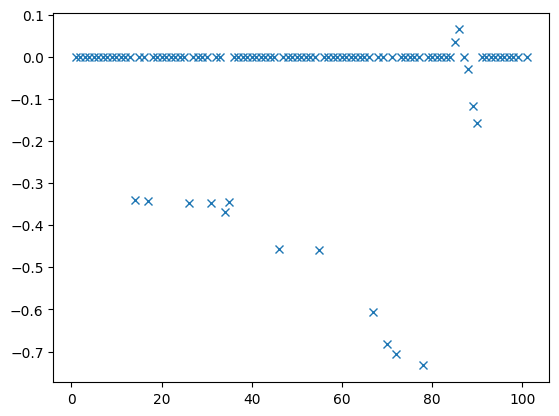

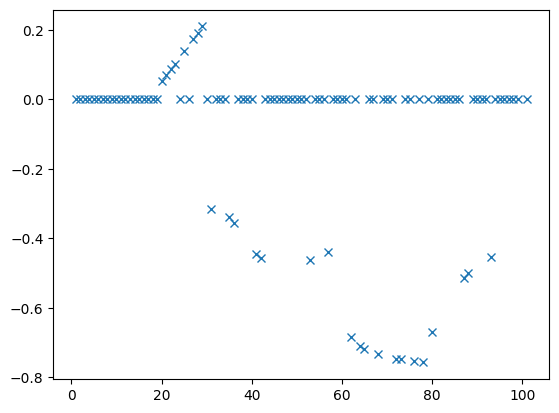

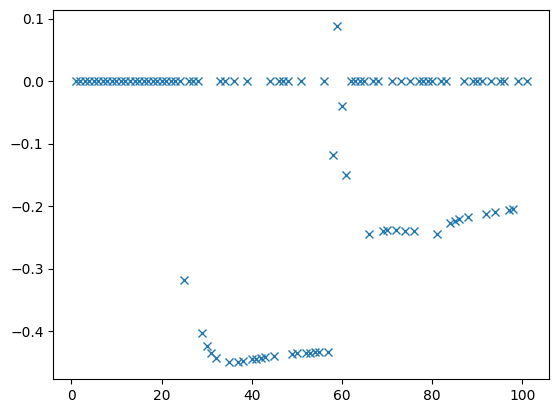

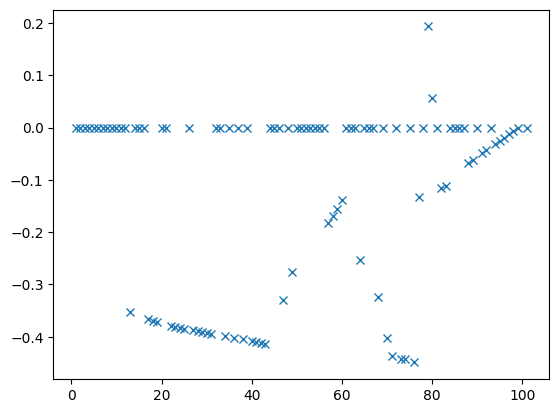

In [ ]:
max_length = 100
min_points = 10
max_points = 50

X_train_output = np.zeros((X_train.shape[0], max_length, 9))
time_list = np.zeros((X_train.shape[0], max_length))
mask = np.zeros((X_train.shape[0], max_length, 1))
count = 0
for i in range(X_train.shape[0]):
    sorted_t = sampler(min_num_points=min_points, count=count, max_num_points=max_points, max_duration=max_length)
    length_t = len(sorted_t)
    t_list = []
    x_1 = [] #note x refers to features not states here
    x_2 = []
    x_3 = []
    x_4 = []
    x_5 = []
    x_6 = []
    x_7 = []
    x_8 = []
    x_9 = []


    for j in range(max_length):
        if j in sorted_t:
            x_6.append(X_train[i, j, 5])
            x_7.append(X_train[i, j, 6])
            x_8.append(X_train[i, j, 7])
            x_9.append(X_train[i, j, 8])



        else:
            x_6.append(0)
            x_7.append(0)
            x_8.append(0)
            x_9.append(0)
            # t_list.append(0)


        t_list.append(t_train[i, j])
        x_1.append(X_train[i, j, 0])
        x_2.append(X_train[i, j, 1])
        x_3.append(X_train[i, j, 2])
        x_4.append(X_train[i, j, 3])
        x_5.append(X_train[i, j, 4])

    all_mask = [1 * len(sorted_t)]
    time_list[count, :] = np.array(t_list)
    X_train_output[count, :, :] = np.array([x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9]).T
    count += 1
    if count%1e3==0:
        plt.plot(t_list, np.array(x_7), 'x')
        plt.show()

In [ ]:
# y_train = y_train_output
t_train = time_list
X_train = np.concatenate((X_train_output, t_train.reshape(-1, max_length, 1)), axis = 2)

In [ ]:
X_train = X_train[:, :, 0:9]
X_val = X_val[:, :, 0:9]
X_test1 = X_test[:, :, 0:9]
print(f'x_train, x_val, x_test shapes: {X_train.shape}, {X_val.shape}, {X_test1.shape}')

x_train, x_val, x_test shapes: (5197, 100, 9), (1733, 100, 9), (2971, 100, 9)


In [ ]:
t_train1 = torch.from_numpy(t_train).float()
t_val1 = torch.from_numpy(t_val).float()
t_test1 = torch.from_numpy(t_test).float()
print(t_train1.size())

torch.Size([5197, 100])


In [ ]:
batch_size = 256

train_features = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).float()
val_features = torch.from_numpy(X_val).float()
val_targets = torch.from_numpy(y_val).float()
test_features = torch.from_numpy(X_test1).float()
test_targets = torch.from_numpy(y_test).float()
# train_mask = torch.from_numpy(mask).float().to(device)


In [ ]:
# move to gpu
train_features = train_features.to(device)
train_targets = train_targets.to(device)
val_features = val_features.to(device)
val_targets = val_targets.to(device)
test_features = test_features.to(device)
test_targets = test_targets.to(device)
t_train1 = t_train1.to(device)
t_val1 = t_val1.to(device)
t_test1 = t_test1.to(device)

In [ ]:
print(val_features.shape)
print(val_targets.shape)
print(t_val1.shape)
print(t_train1.shape)

torch.Size([1733, 100, 9])
torch.Size([1733, 1, 4])
torch.Size([1733, 100])
torch.Size([5197, 100])


In [ ]:
train = TensorDataset(train_features, train_targets, t_train1)
val = TensorDataset(val_features, val_targets, t_val1)
test = TensorDataset(test_features, test_targets, t_test1)

train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [ ]:
class Net(nn.Module):
    # constructor
    def __init__(self, layers):
        super(Net, self).__init__()
        # plstm layer
        self.input_size = layers[0] #input to plstm = 4
        self.hidden_size1 = layers[1]
        self.linear_size = layers[0] #convert back to 4

        # concantenate layer
        self.conc = 9

        self.hidden_size2 = layers[2]
        self.output_size = layers[3]
        # hidden layer
        self.PLSTM = PLSTM(self.input_size, self.hidden_size1)
        self.linear = nn.Linear(self.hidden_size1, self.linear_size)

        self.LSTM  = nn.LSTM(self.conc, self.hidden_size2, batch_first=True)
        # output layer
        self.output = nn.Linear(self.hidden_size2, self.output_size)

    # predict
    def forward(self, x, t):
        # x is in the shape of (batch size, sequence length, input_variables)
        # print("x dimensions before slicing:", x.shape)
        state = x[:, :, 5:9]
        u = x[:, :, 0:5]
        self.hidden_seq, ht, kt = self.PLSTM(state, t)
        self.shift= kt[0]
        self.period = kt[1]
        self.on_end = kt[2]

        plstm_out = self.linear(self.hidden_seq)
        combined = torch.cat((plstm_out, u), dim=2)

        lstm_out, _ = self.LSTM(combined)
        out = self.output(lstm_out)

         # use the last index of RNN output
        # out = self.hidden_seq
        out = out[:,-1,:] # shape: [batch size, sequence length, input_variables]



        return out.reshape(-1, 1, self.output_size)

    def get_on_end_parameter(self):
        return self.PLSTM.get_on_end_parameter()

In [ ]:
def train(model, epochs, optimizer, criterion, trainloader, val_loader):
    TRAIN_LOSS = []
    VAL_LOSS = []
    shift_change = []
    period_change = []
    on_mid_change = []
    on_end_change = []

    best_val_loss = float('inf')
    patience = 5  # Number of epochs to wait for improvement
    counter = 0
    target_val_loss = 1e-4  # Define the target validation loss for early stopping
    early_stopping_triggered = False  # Flag to indicate whether early stopping has been triggered
    # save_path = 'PLSTM_best.pth'

    for epoch in range(epochs):
        start_time = time.time()
        BATCH_LOSS = []
        for x, y, t in trainloader:
            optimizer.zero_grad()
            yhat = model(x, t)
            loss = criterion(yhat, y)
            # masked_loss = (loss * Xmask.float()).sum()/Xmask.sum()
            # masked_loss.backward()
            loss.backward()

            # Clip gradients using torch.nn.utils.clip_grad_value_
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=100)

            # Constraint: Clamp On_End parameter values between -1 and 1 (doesnt work)
            # on_end_param = model.get_on_end_parameter()
            # on_end_param.data.clamp_(-1, 1)

            optimizer.step()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient: {param.grad}')

            BATCH_LOSS.append(loss.cpu().item())
        training_loss = np.mean(BATCH_LOSS)
        TRAIN_LOSS.append(training_loss)

        # validation
        with torch.no_grad(): #disable gradient calculation
            # set model to eval mode
            model.eval()
            val_loss = 0.0
            BATCH_VAL_LOSS = []
            for x_val, y_val, t_val in val_loader:
                ypred = model(x_val, t_val)
                loss_val = criterion(ypred, y_val)
                BATCH_VAL_LOSS.append(loss_val.cpu())
                val_loss += loss_val.cpu().item()

        val_loss /= len(val_loader)
        validation_loss = np.mean(BATCH_VAL_LOSS)
        VAL_LOSS.append(validation_loss)

        # Update learning rate scheduler based on validation loss
        # scheduler.step(val_loss)

        # Check for early stopping
        # Check if the validation loss reaches the desired threshold
        if val_loss <= target_val_loss:
            early_stopping_triggered = True

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # torch.save(model.state_dict(), save_path)
        else:
            counter += 1
            if counter >= patience and early_stopping_triggered:
                print(f"Early stopping!, val_loss{val_loss}")
                break  # Stop training


        shift_change.append(model.shift.cpu().detach().numpy())
        period_change.append(model.period.cpu().detach().numpy())
        on_end_change.append(model.on_end.cpu().detach().numpy())
        end_time = time.time()
        time_taken = end_time - start_time
        print(f'Epoch {epoch+1}/{epochs}, {time_taken:.4f}s, loss = {training_loss: .5e}, val_loss = {validation_loss:.5e}, r_on: {model.on_end.cpu().detach().numpy()[0][0]}')
    return TRAIN_LOSS, VAL_LOSS, shift_change, period_change, on_mid_change, on_end_change

In [ ]:
torch.manual_seed(123)
layers = [4, 64, 32, 4]
model = Net(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001) #default lr
criterion = nn.MSELoss()

In [ ]:
model.parameters

<bound method Module.parameters of Net(
  (PLSTM): PLSTM()
  (linear): Linear(in_features=64, out_features=4, bias=True)
  (LSTM): LSTM(9, 32, batch_first=True)
  (output): Linear(in_features=32, out_features=4, bias=True)
)>

In [ ]:
TRAIN_LOSS, VAL_LOSS, shift_change, period_change, on_mid_change, on_end_change= train(model=model, epochs=500, optimizer=optimizer, criterion=criterion, trainloader=train_loader, val_loader=val_loader)

Epoch 1/500, 9.0398s, loss =  9.48811e-01, val_loss = 8.50247e-01, r_on: 0.0533410981297493
Epoch 2/500, 6.5531s, loss =  8.00824e-01, val_loss = 6.46652e-01, r_on: 0.06659797579050064
Epoch 3/500, 7.0048s, loss =  5.46731e-01, val_loss = 4.36870e-01, r_on: 0.07845039665699005
Epoch 4/500, 6.3733s, loss =  4.03963e-01, val_loss = 3.42146e-01, r_on: 0.0715242251753807
Epoch 5/500, 7.0540s, loss =  3.30100e-01, val_loss = 2.92992e-01, r_on: 0.07230321317911148
Epoch 6/500, 6.4111s, loss =  2.84938e-01, val_loss = 2.77184e-01, r_on: 0.08242128789424896
Epoch 7/500, 6.9298s, loss =  2.58845e-01, val_loss = 2.63377e-01, r_on: 0.08574444055557251
Epoch 8/500, 6.7025s, loss =  2.36062e-01, val_loss = 2.55130e-01, r_on: 0.08788122236728668
Epoch 9/500, 6.5605s, loss =  2.22140e-01, val_loss = 2.21522e-01, r_on: 0.09191777557134628
Epoch 10/500, 6.9204s, loss =  2.10284e-01, val_loss = 2.05749e-01, r_on: 0.09000209718942642
Epoch 11/500, 6.3444s, loss =  1.97648e-01, val_loss = 1.97100e-01, r_o

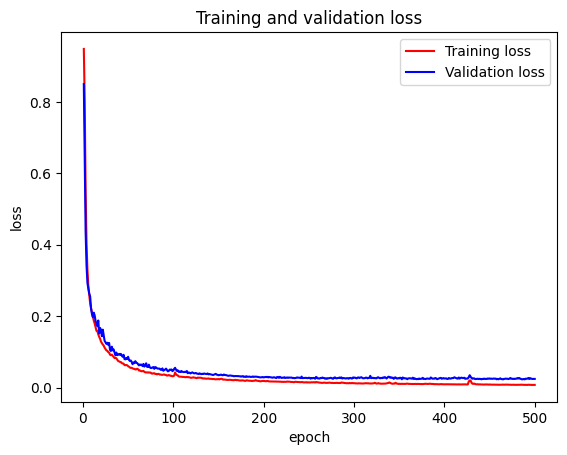

In [ ]:
length = len(TRAIN_LOSS)
epochs = range(1, length+1)
plt.plot(epochs, TRAIN_LOSS, 'r', label='Training loss')
plt.plot(epochs, VAL_LOSS, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
np.savetxt('val_loss_plstm.txt', VAL_LOSS)
np.savetxt('train_loss_plstm.txt', TRAIN_LOSS)

In [ ]:
def test_eval(model, criterion, testloader):
    with torch.no_grad(): #disable gradient calculation
    # set model to et mode
        model.eval()

        BATCH_t_LOSS = []
        for x_t, y_t, t_t in testloader:
            ypredt = model(x_t, t_t)
            loss_t = criterion(ypredt, y_t)
            BATCH_t_LOSS.append(loss_t.cpu())
    testing_loss = np.mean(BATCH_t_LOSS)
    return testing_loss

In [ ]:
print(test_eval(model, criterion=criterion, testloader=test_loader))

0.026735008


In [ ]:
y_predict = []
for i, (x_t, y_t, t_t) in enumerate(test_loader):
    y_pred = model(x_t, t_t)
    y_predict.append(y_pred.cpu().detach().numpy())
    if i == 9:
        break

y_predict = np.array(y_predict)


y_predict=y_predict.reshape(-1,4) #additional line
y_predict = scaler_y.inverse_transform(y_predict)
y_predict=y_predict.reshape(-1,1,4) #additional

X_plot=X_test.reshape(-1,10) #additional line
X_plot = scaler_X.inverse_transform(X_plot)
X_plot=X_plot.reshape(-1,100,10) #additional
time_input = X_plot[:, :, -1]
X_plot = X_plot[:, :, 0:9]

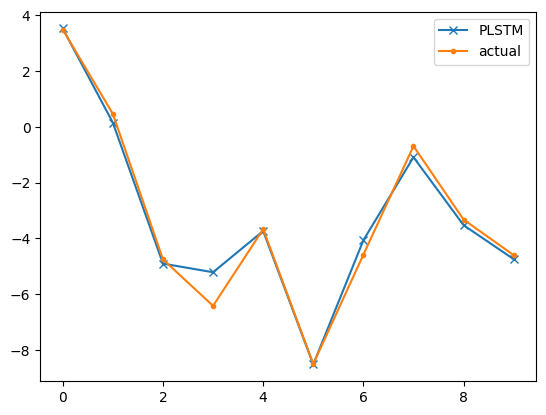

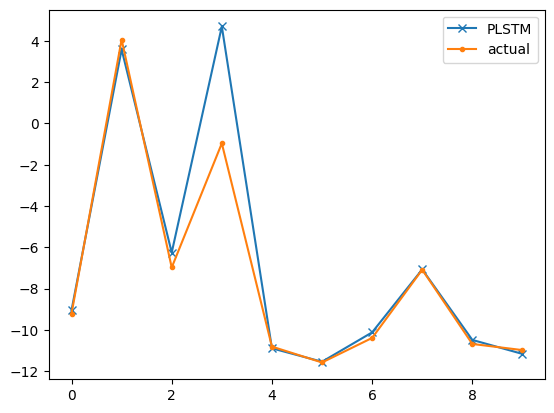

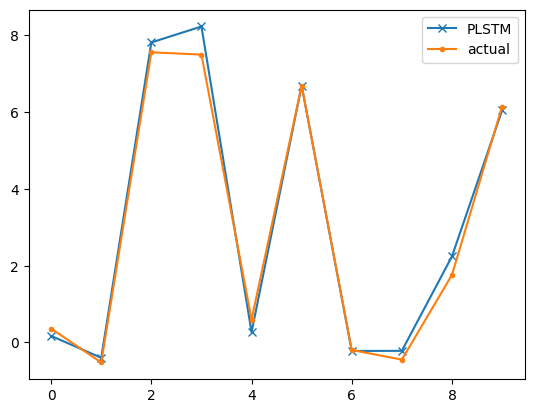

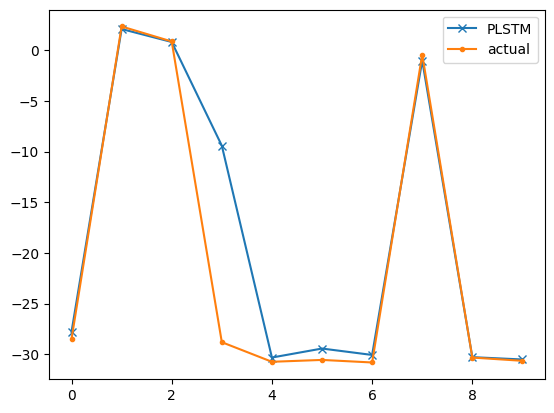

In [ ]:
for i in range(4):
    plt.plot(y_predict[0:10, :, i], 'x-', label='PLSTM')
    plt.plot(y_test1[0:10, :, i], '.-', label='actual')
    plt.legend()
    plt.show()

In [ ]:
# save model
save_path = 'PLSTM_110_new.pth'
torch.save(model.state_dict(), save_path)